Adapted from: https://www.kaggle.com/mayer79/m5-forecast-keras-with-categorical-embeddings

In [1]:
!pip install graphviz
!pip install pydot

In [2]:
import pandas as pd
import gc
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder

In [3]:
data = pd.read_pickle("/home/wsuser/work/project_data_assets/data_asset/full_data.pkl")

In [4]:
columns_to_encode = ["wday", "month", "year", "item_id", "dept_id", "store_id"]

encoders = {}
for column in columns_to_encode:
    encoders[column] = OrdinalEncoder()
    data[column] = encoders[column].fit_transform(data[[column]]).astype("uint16")

In [5]:
train_df = data.loc[data.part == 'train']
test_df = data.loc[data.part == 'test1']
del data
gc.collect()

49

In [6]:
x_val = train_df.loc[(train_df['date'] > '2016-03-27') & (train_df['date'] <= '2016-04-24')]
train_df = train_df.loc[train_df['date'] <= '2016-03-27']

In [7]:
numerical_features = ["lag_t28", "rolling_mean_t30", "price_change_t365", "rolling_std_t30", "price_change_t1", "sell_price"]

In [8]:
train_df[numerical_features] = MinMaxScaler().fit_transform(train_df[numerical_features])
train_df.fillna(0, inplace = True)

/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float16, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [9]:
def make_Xy(df, ind=None, return_y = True):
    if ind is not None:
        df = df[ind]
    X = {"dense1": df[["lag_t28", "rolling_mean_t30", "price_change_t365", "rolling_std_t30", "price_change_t1",
                       "snap_CA", "snap_TX", "snap_WI", "sell_price"]].to_numpy(dtype="float32"),
         "item_id": df[["item_id"]].to_numpy(dtype="uint8")}
    for i, v in enumerate(["wday", "month", "year", "event_name_1", 
                           "event_type_1", "event_name_2", 
                           "event_type_2", "item_id", "dept_id", "store_id"]):
        X[v] = df[[v]].to_numpy(dtype="uint32")
    if return_y:
        return X, df.demand.to_numpy(dtype="float32")
    else:
        return X

In [10]:
X_train, y_train = make_Xy(train_df, return_y=True)

In [11]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

tf.keras.backend.clear_session()  # For easy reset of notebook state.

from tensorflow.keras.layers import Dense, Input, Embedding, Dropout, concatenate, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

In [12]:
# Dense part
dense_input = Input(shape=(9, ), name='dense1')
dense_branch = Dense(100, activation="relu")(dense_input)
#dense_branch = Dense(100, activation="relu")(dense_branch)

# Embedded input
wday_input = Input(shape=(1,), name='wday')
month_input = Input(shape=(1,), name='month')
year_input = Input(shape=(1,), name='year')
event_name_1_input = Input(shape=(1,), name='event_name_1')
event_type_1_input = Input(shape=(1,), name='event_type_1')
event_name_2_input = Input(shape=(1,), name='event_name_2')
event_type_2_input = Input(shape=(1,), name='event_type_2')
item_id_input = Input(shape=(1,), name='item_id')
dept_id_input = Input(shape=(1,), name='dept_id')
store_id_input = Input(shape=(1,), name='store_id')

# Embedding layers
wday_emb = Flatten()(Embedding(7, 2)(wday_input))
month_emb = Flatten()(Embedding(12, 2)(month_input))
year_emb = Flatten()(Embedding(6, 2)(year_input))
event_name_1_emb = Flatten()(Embedding(31, 5)(event_name_1_input))
event_type_1_emb = Flatten()(Embedding(5, 2)(event_type_1_input))
event_name_2_emb = Flatten()(Embedding(5, 2)(event_name_2_input))
event_type_2_emb = Flatten()(Embedding(5, 2)(event_type_2_input))
item_id_emb = Flatten()(Embedding(3049, 30)(item_id_input))
item_id_emb = Dropout(0.3)(item_id_emb)
dept_id_emb = Flatten()(Embedding(7, 2)(dept_id_input))
store_id_emb = Flatten()(Embedding(10, 2)(store_id_input))

x = concatenate([dense_branch, wday_emb, month_emb, year_emb, event_name_1_emb,
                event_type_1_emb, event_name_2_emb, event_type_2_emb, item_id_emb, dept_id_emb, store_id_emb])
x = Dense(150, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(20, activation="relu")(x)
prediction = Dense(1, activation="linear", name='output')(x)

#model = Model(inputs={"dense1": dense_input, "wday": wday_input, "month": month_input, 
#                      "year": year_input, "event_name_1": event_name_1_input, "event_type_1": event_type_1_input, 
#                      "item_id": item_id_input, "dept_id": dept_id_input, "store_id": store_id_input},
#              outputs=prediction)
model = Model([dense_input, wday_input, month_input, year_input, event_name_1_input, event_type_1_input, 
               event_name_2_input, event_type_2_input, item_id_input, dept_id_input, store_id_input], outputs=prediction)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [13]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
item_id (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
wday (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
month (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
year (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
event_name

In [14]:
model.compile(loss=keras.losses.mean_squared_error,
              optimizer="rmsprop",
              metrics=['mse'])

history = model.fit(X_train, 
                    y_train,
                    batch_size=4096,
                    epochs=10,
                    validation_split=0.1)

Train on 51726285 samples, validate on 5747365 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
51726285/51726285 [==============================] - 360s 7us/sample - loss: 6.4501 - mean_squared_error: 6.4501 - val_loss: 5.6012 - val_mean_squared_error: 5.6012
Epoch 2/10
51726285/51726285 [==============================] - 371s 7us/sample - loss: 6.1355 - mean_squared_error: 6.1356 - val_loss: 5.5688 - val_mean_squared_error: 5.5688
Epoch 3/10
51726285/51726285 [==============================] - 355s 7us/sample - loss: 6.0214 - mean_squared_error: 6.0214 - val_loss: 5.4933 - val_mean_squared_error: 5.4933
Epoch 4/10
51726285/51726285 [==============================] - 373s 7us/sample - loss: 5.9375 - mean_squared_error: 5.9375 - val_loss: 5.5580 - val_mean_squared_error: 5.5580
Epoch 5/10
51726285/51726285 [==============================] - 360s 7us/sample - loss: 5.8838 - mean_squared_error: 5.8838 - val_loss: 5.4402 - val_mean_squared_error: 5.4402
Epoch 6/10
517262

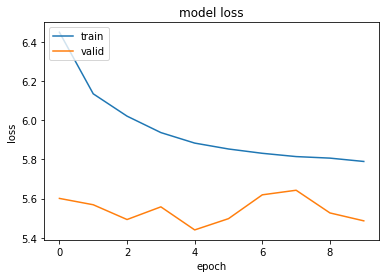

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [ ]:
model.save('model_train.h5')

In [17]:
x_val[numerical_features] = MinMaxScaler().fit_transform(x_val[numerical_features])
x_val.fillna(0, inplace = True)

In [18]:
X_test = make_Xy(x_val, return_y = False)
pred = model.predict(X_test)

In [19]:
def create_kaggle_submission_file(test):
    predictions = test[['id', 'date', 'demand']]
    predictions = pd.pivot(predictions, index = 'id', columns = 'date', values = 'demand').reset_index()
    predictions.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]
    
    submission = pd.read_csv('/project_data/data_asset/sample_submission.csv')
    evaluation_rows = [row for row in submission['id'] if 'evaluation' in row] 
    evaluation = submission[submission['id'].isin(evaluation_rows)]

    validation = submission[['id']].merge(predictions, on = 'id')
    final = pd.concat([validation, evaluation])
    return final

In [20]:
x_val['demand'] = pred
kaggle_submission = create_kaggle_submission_file(x_val)

In [21]:
sales_train_validation = pd.read_csv('/project_data/data_asset/sales_train_validation.csv')
prices = pd.read_csv('/project_data/data_asset/sell_prices.csv')
calendar = pd.read_csv('/project_data/data_asset/calendar.csv')

train_fold_df = sales_train_validation.iloc[:, :-28]
valid_fold_df = sales_train_validation.iloc[:, -28:]

In [22]:
validation_rows = [row for row in kaggle_submission['id'] if 'validation' in row] 
kaggle_submission = kaggle_submission[kaggle_submission['id'].isin(validation_rows)]
valid_preds = kaggle_submission.iloc[:, 1:]
valid_preds.columns = valid_fold_df.columns

In [24]:
!pip install tqdm -U

     |################################| 61kB 636kB/s eta 0:00:011
  Found existing installation: tqdm 4.31.1
    Uninstalling tqdm-4.31.1:
      Successfully uninstalled tqdm-4.31.1


In [25]:
from metrics import WRMSSEEvaluator

In [26]:
evaluator = WRMSSEEvaluator(train_fold_df, valid_fold_df, calendar, prices)
evaluator.score(valid_preds)

9.167480153859637